## SAGA Paper 4, FIGURE 8:  SFS EXTERNAL COMPARISON
             

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize

%matplotlib inline
import astropy.constants


from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import kurtosis, skew

import matplotlib.lines as mlines

import matplotlib
import matplotlib.backends.backend_pdf

import SAGA  
from easyquery import QueryMaker
from SAGA import ObjectCuts as C

from easyquery import Query
from SAGA.database import FitsTable 

IMF Conversions based on Madau & Dickinson:

stellar mass:   SFR_SAL = SFR_Kroup/0.66 = SFR_CH/0.61

stellar mass:   SFR_K = 1.08 M*_Chabier = 0.66 M*_Salpeter

M*_Kroupa = 1.08 M*_Chabier
 

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
def a_line(x,*p) :
    return p[0]+p[1]*x


def fit_a_line(x,y,err,name):
    p0 = [1,-9]
    p, pcov = curve_fit(a_line, x, y, sigma=err,p0=p0)

    
    perr = np.sqrt(np.diag(pcov))
    
    xf = np.arange(-5,11,0.25)
    yf = a_line(xf,*p)
    
    rms = np.mean(np.abs(y -(p[0]+p[1]*x)))
    sk = skew(y -(p[0]+p[1]*x))
    print('{}:  m, b, rms, sk:  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}'.format(name,p[1],p[0],rms,sk))
    
    
    return xf,yf, p[1],p[0], rms,sk

In [4]:
base = saga.host_catalog.construct_host_query("paper3").\
                     filter(saga.object_catalog.load_combined_base_catalog())

In [5]:
qlow = Query("SPEC_Z < 0.2","SATS == 0")
lowz = Query(qlow).filter(base, ["nuv_sfr","nuv_sfr_err","nuv_mag_flag" ,"log_sm",'SPEC_Z'])

In [6]:
qsats = Query("SATS == 1")
sats = Query(qsats).filter(base, ["nuv_sfr","nuv_sfr_err" ,"nuv_mag_flag", "log_sm","quenched",'RHOST_KPC'])

### Literature values

In [7]:
x_sagabg = np.arange(6,10.3,0.1)
y_sagabg  = 0.8 * (x_sagabg - 8.5) - 1.45

In [8]:
x_peng =np.arange(6,10.3,0.1)  
Mstar  = x_peng - 0.03
y_peng = -10.0 -0.1*(Mstar-10) + Mstar + 0.03


# DALE23, Chabrier IMF
# http://arxiv.org/abs/2304.12491
m = 0.878
b = -9.029    # WHERE ARE THESE FROM??  

x_dale = np.arange(6,10.3,0.1)
Mstar  = x_dale  - 0.03
y_dale = m*Mstar+b  + 0.03

# LEROY 2019:  PUBLISHED VALUES
# Eq 19
# IMF KROUPA & WEIDNER, not making a correction
x_leroy = np.arange(9,11,0.1)
y_leroy = -0.32 * (x_leroy - 10) - 10.17 + x_leroy


# FROM FIGURE 4
msaga = 0.82  
bsaga = -8.51
xsats = np.arange(6,10.3,0.1)
ysats = msaga*xsats + bsaga

In [9]:
mnuv     = (sats['quenched'] ==0)  & (sats['nuv_sfr_err'] < 0.25)# & (sats['RHOST_KPC'] > 100)
mup  = sats['nuv_mag_flag'] ==0
print('NUV galaxies: ',np.sum(mnuv))

NUV galaxies:  268


In [10]:
ssfr = lowz['nuv_sfr'] - lowz['log_sm'] - lowz['nuv_sfr_err']


msm = (lowz['log_sm'] > 7.5) & (lowz['log_sm'] < 9)& (lowz['log_sm'] >7.5)

mlz = (lowz['nuv_mag_flag'] >-1) & (lowz['SPEC_Z'] < 0.035) & (ssfr > -11.) #&msm

muplz = (lowz['nuv_mag_flag'] ==0) & (lowz['SPEC_Z'] < 0.035) & (ssfr > -11.) #&msm


xbg     = lowz['log_sm'][mlz]
ybg     = lowz['nuv_sfr'][mlz]
ybgs    = lowz['nuv_sfr'][mlz]-lowz['log_sm'][mlz]
ybg_err = lowz['nuv_sfr_err'][mlz]


mlz = (lowz['nuv_mag_flag'] ==1) & (lowz['SPEC_Z'] < 0.035) & (ssfr > -11.) &msm
print(np.sum(mlz))

xbg2     = lowz['log_sm'][mlz]
ybg2     = lowz['nuv_sfr'][mlz]
ybgs2    = lowz['nuv_sfr'][mlz]-lowz['log_sm'][mlz]
ybg_err2 = lowz['nuv_sfr_err'][mlz]


413


In [11]:
exf,eyf,e_m,e_b,erms,esk = fit_a_line(xbg,ybg,ybg_err,'SAGAbg, NUV')

xsagabg_nuv = np.arange(6,10.3,0.1)
ysagabg_nuv = e_m*xsagabg_nuv + e_b


##################
# OR FIT IN STELLAR MASS RANGE
exf,eyf,e_m,e_b,erms,esk = fit_a_line(xbg2,ybg2,ybg_err2,'SAGAbg, NUV')

xsagabg_nuv = np.arange(6,10.3,0.1)
ysagabg_nuv = e_m*xsagabg_nuv + e_b

SAGAbg, NUV:  m, b, rms, sk:  0.69  -7.34  0.25  -0.33
SAGAbg, NUV:  m, b, rms, sk:  0.63  -6.83  0.20  -0.20


In [12]:
pbins = np.linspace(0, 100, 8)
log_sm = np.concatenate([sats['log_sm']])
log_sm = log_sm[log_sm >= 6.75]
bins = np.percentile(log_sm, pbins)
x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)


In [13]:
def bin_wmean(bins,x,y,yerr):
    
    wmean,werr1, werr2 = [],[],[]
    
    for i,b in enumerate(bins[:-1]):
        m = (x>bins[i]) & (x<bins[i+1])
        
        xx = np.percentile(y[m], [16, 50, 84]) 
        
        wmean.append(xx[1])
        werr1.append(xx[1] - xx[0])
        werr2.append(xx[2] - xx[1])
        
                     
    return wmean,werr1,werr2


def plot_sfs(sats_sm, sats_sfr, sats_sfr_err, label, color, ax):
    
    s=8
    ss = 4
    
    blabel = label+" binned"
    slabel = label+' satellites'
    if label == 'Ha':
        blabel = r'${\rm H}\alpha$ binned'
        slabel = r'${\rm H}\alpha$ satellites'
    
    ax.plot(sats_sm, sats_sfr,'o',c='grey',ms=ss,alpha=0.7,label=slabel)

    
    ax.errorbar(sats_sm, sats_sfr,yerr = sats_sfr_err,\
                alpha=0.3,fmt='none',color='grey')

    a,b,c = bin_wmean(bins,sats_sm,sats_sfr,sats_sfr_err)
    ax.plot(x,a,'s',c=color,ms=8,label=blabel)
    ax.errorbar(x,a,yerr=[b,c],ls='none',c=color,ms=8,alpha=0.7,lw=4)
    ax.plot(x,a,'s',c='k',ms=9,alpha=0.7,mfc='none')

    
    return ax

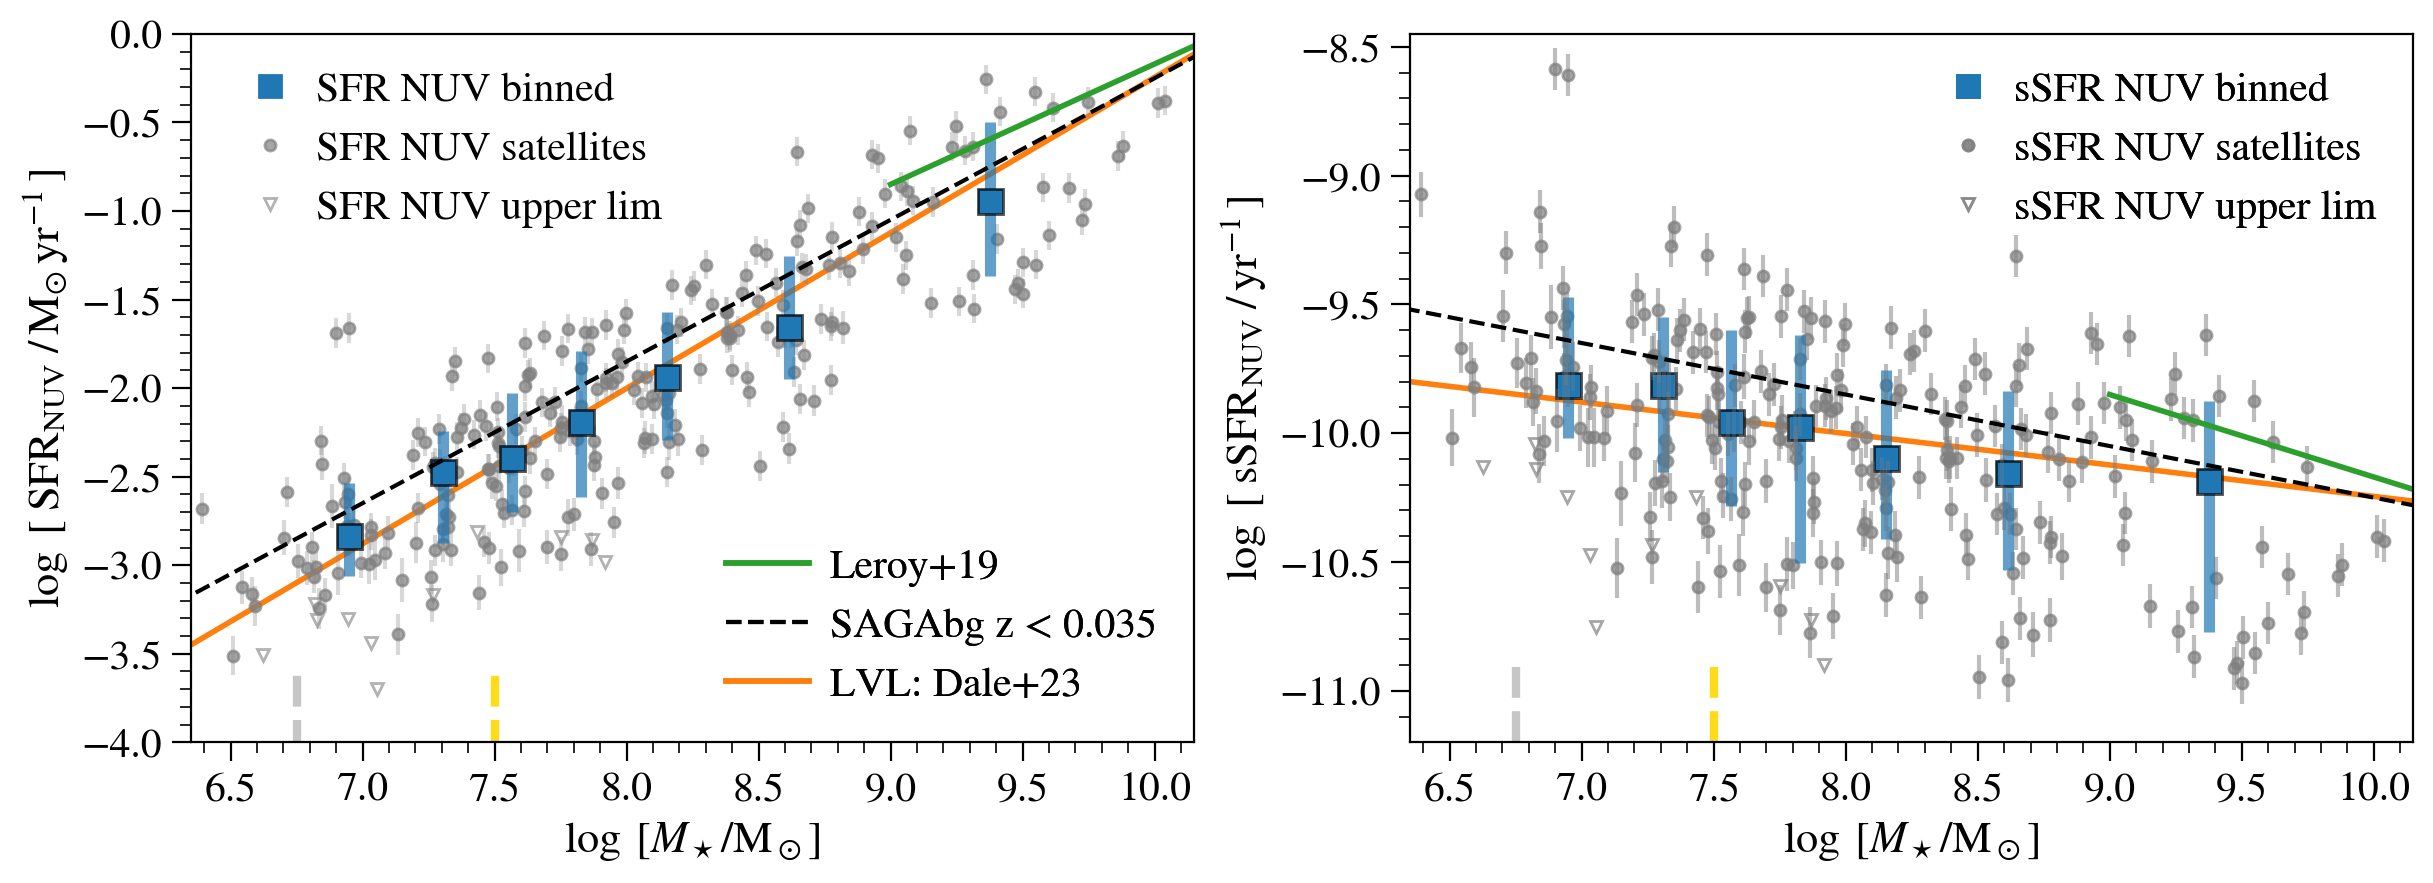

In [14]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_SFS_ext.pdf')

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.9))


#############
ax1 = plot_sfs(sats['log_sm'][mnuv&~mup],sats['nuv_sfr'][mnuv&~mup],sats['nuv_sfr_err'][mnuv&~mup],\
                                'SFR NUV', 'C0', ax1)

ax1.plot(sats['log_sm'][mup&mnuv],sats['nuv_sfr'][mup&mnuv],'v',c='grey',mfc='none',\
         alpha=0.6,ms=4,label='SFR NUV upper lim')


ax2 = plot_sfs(sats['log_sm'][mnuv&~mup],sats['nuv_sfr'][mnuv&~mup]-sats['log_sm'][mnuv&~mup],\
         sats['nuv_sfr_err'][mnuv&~mup],\
         'sSFR NUV', 'C0', ax2)


ax2.plot(sats['log_sm'][mup&mnuv],sats['nuv_sfr'][mup&mnuv]-sats['log_sm'][mnuv&mup],'v',mfc='none',\
         c='grey',alpha=0.7,label='sSFR NUV upper lim',ms=4)

ax2.errorbar(sats['log_sm'][mnuv&~mup],sats['nuv_sfr'][mnuv&~mup]-sats['log_sm'][mnuv&~mup],yerr = sats['nuv_sfr_err'][mnuv&~mup],alpha=0.3,\
                                                            fmt='none',color='grey')


handles, labels = ax1.get_legend_handles_labels()
order = [1,0,2]
l1 = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
          handletextpad=0.1,loc='upper left')

ax1.add_artist(l1)

handles, labels = ax2.get_legend_handles_labels()
order = [1,0,2]
l2 = ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
          handletextpad=0.1,loc='upper right')
ax2.add_artist(l2)


ax1.set_ylim(-4.,0.)
ax2.set_ylim(-11.2,-8.45)


ax1.set_xlim(6.35,10.15)
ax2.set_xlim(6.35,10.15)

###############################################
# ADD LINES


ax1.plot(x_sagabg,y_sagabg,label='SAGAbg z < 0.035',c='k',ls='--')
ax2.plot(x_sagabg,y_sagabg-x_sagabg,label='SAGAbg z < 0.035',c='k',ls='--')


ax1.plot(x_dale,y_dale,label='LVL: Dale+23',c='C1',ls='-',lw=2,zorder=0)
ax2.plot(x_dale,y_dale-x_dale,label='LVL: Dale+23',c='C1',ls='-',lw=2,zorder=0)

ax1.plot(x_leroy,y_leroy,label='Leroy+19',c='C2',lw=2)
ax2.plot(x_leroy,y_leroy-x_leroy,label='Leroy+19',c='C2',lw=2)

handles, labels = ax1.get_legend_handles_labels()
order = [5,3,4]
l3 = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
          handletextpad=0.5,loc='lower right')
ax1.add_artist(l3)


ax1.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax2.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')


ax1.set_ylabel(r'$\log~[\;{\rm SFR}_{\rm NUV} \; / \, {\rm M}_{\odot}\,{\rm yr}^{-1}\,]$')
ax2.set_ylabel(r'$\log~[\;{\rm sSFR}_{\rm NUV} \; / \, {\rm yr}{^{-1}}\,$]')


ax1.plot([7.5,7.5],[-4.3,-3.6],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax1.plot([6.75,6.75],[-4.3,-3.6],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)
ax2.plot([7.5,7.5],[-11.2,-10.9],ls='--',c='gold',alpha=0.9,zorder=0,lw=3)
ax2.plot([6.75,6.75],[-11.2,-10.9],ls='--',c='silver',alpha=0.9,zorder=0,lw=3)

pdf.savefig()
pdf.close()